# CSE 258, Fall 2019: Homework 3
**You’ll probably want to implement your solution by modifying the baseline code provided.**   
Files: 
* http://cseweb.ucsd.edu/classes/fa19/cse258-a/files/assignment1.tar.gz   

Kaggle:
* https://inclass.kaggle.com/c/cse158258-fa19-read-prediction
* (258 only) https://inclass.kaggle.com/c/cse258-fa19-rating-prediction

# Tasks (Read prediction)   
Since we don’t have access to the test labels, we’ll need to simulate validation/test sets of our own.    
So, let’s split the training data (‘train Interactions.csv.gz’) as follows:
1. Reviews 1-190,000 for training
2. Reviews 190,001-200,000 for validation
3. Upload to Kaggle for testing only when you have a good model on the validation set. This will save you time (since Kaggle can take several minutes to return results), and prevent you from exceeding your daily submission limit.

In [54]:
import gzip
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy

In [55]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
    
def readCSV(path):
    f = gzip.open(path, 'rt')
    header = f.readline()
    for l in f:
        yield l.strip().split(',')

In [56]:
data = [line[:2] + [1] for line in readCSV("train_Interactions.csv.gz")] # 1 is the label saying it is read.

## Task 1
Although we have built a validation set, it only consists of positive samples. For this task we also need examples of user/item pairs that weren’t read. For each entry (user,book) in the validation set, sample a negative entry by randomly choosing a book that user hasn’t read. Evaluate the performance (accuracy) of the baseline model on the validation set you have built (1 mark).

In [57]:
Xy_train = data[:190000]
Xy_valid = data[190000:]
# First get overview of what books each user have read, and what what user a book has been read by.
usersPerBook = defaultdict(set)
bookPerUser = defaultdict(set)
for line in data:
    userID, bookID, rating = line
    usersPerBook[bookID].add(userID)
    bookPerUser[userID].add(bookID)

# Randomly ad some negative samples to the validation set
negative_samples = []
available_books = usersPerBook.keys()
for user, book, has_read in Xy_valid:
    #print(user,book)
    random_book = random.choice(list(available_books))
    while random_book in bookPerUser[user]:
        random_book = random.choice(list(available_books))
    new_data = [user, random_book, 0]
    negative_samples.append(new_data)
Xy_valid += negative_samples # Add the negative data
random.shuffle(Xy_valid)

Xtrain, ytrain = [d[:2] for d in Xy_train], [d[2] for d in Xy_train]
Xvalid, yvalid = [d[:2] for d in Xy_valid], [d[2] for d in Xy_valid]

In [58]:
def accuracy(predictions, labels):
    predictions, labels = np.array(predictions), np.array(labels)
    return sum(predictions == labels) / len(predictions)

def most_popular_percentile(mostPopular, percentile):
    return1 = set()
    count = 0
    for b_count, b in mostPopular:
        count += b_count
        return1.add(b)
        if count > percentile * totalRead: break
    return return1

In [59]:
### Would-read baseline: just rank which books are popular and which are not, and return '1' if a book is among the top-ranked

bookCount = defaultdict(int)
totalRead = 0

for user,book in Xtrain:
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort(reverse=True)

return1 = most_popular_percentile(mostPopular, 0.5)

predictions = []
for user, book in Xvalid:
    pred = 1 if book in return1 else 0
    predictions.append(pred)

print("Accuracy: {}".format(accuracy(predictions, yvalid)))

Accuracy: 0.6437


## Task 2
The existing ‘read prediction’ baseline just returns True if the item in question is ‘popular,’ using a threshold of the 50th percentile of popularity (totalRead/2). Assuming that the ‘non-read’ test examples are a random sample of user-book pairs, this threshold may not be the best one. See if you can find a better threshold and report its performance on your validatin set (1 mark).

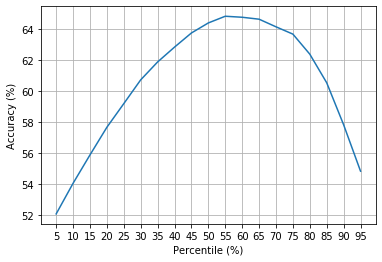

In [61]:
### Would-read baseline: just rank which books are popular and which are not, and return '1' if a book is among the top-ranked
thresholds = np.arange(0.05, 1.0, 0.05)
scores = []
for th in thresholds:
    return1 = most_popular_percentile(mostPopular, th)
    predictions = []
    for user, book in Xvalid:
        pred = 1 if book in return1 else 0
        predictions.append(pred)
    scores.append(accuracy(predictions, yvalid))
    
scores = [100*x for x in scores]
plt.plot(thresholds*100, scores)
plt.xlabel("Percentile (%)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(thresholds*100)
plt.show()

From the graph we can see that it gets the highest accuracy by setting the percentile to 55% instead of 50%. So we use that, and we get an accuracy of:

In [62]:
return1 = most_popular_percentile(mostPopular, 0.55)
predictions = []
for user, book in Xvalid:
    pred = 1 if book in return1 else 0
    predictions.append(pred)
print("Accuracy: {}".format(accuracy(predictions, yvalid)))

Accuracy: 0.648


## Task 3
A stronger baseline than the one provided might make use of the Jaccard similarity (or another similarity
metric). Given a pair (u, b) in the validation set, consider all training items b′ that user u has read. For each, compute the Jaccard similarity between b and b′, i.e., users (in the training set) who have read ′
b and users who have read b . Predict as ‘read’ if the maximum of these Jaccard similarities exceeds a threshold (you may choose the threshold that works best). Report the performance on your validation set (1 mark).

In [63]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [64]:
# Structure the training data into other datastructures
usersPerBook = defaultdict(set)
bookPerUser = defaultdict(set)
for user, book in Xtrain:
    usersPerBook[book].add(user)
    bookPerUser[user].add(book)  

In [65]:
def predict(user, book, threshold=0.03):
    users = usersPerBook[book]
    b_mark = bookPerUser[user]
    
    similarities = []
    for book2 in b_mark:
        if book2 == book:
            continue
        # compute sim between book and book2
        sim = Jaccard(users, usersPerBook[book2])
        similarities.append((sim, book2))
    similarities.sort(reverse=True)
    pred = len(similarities) > 0 and similarities[0][0] > threshold
    return int(pred)

# Make predictions based on Jaccard
threshold = 0.012
predictions = []
for user, book in Xvalid:
    predictions.append(predict(user, book, threshold))
print("Accuracy: {}".format(accuracy(predictions, yvalid)))

Accuracy: 0.6223


## Task 4
Improve the above predictor by incorporating both a Jaccard-based threshold and a popularity based threshold. Report the performance on your validation set (1 mark)

In [67]:
# Predict by using the Jaccard sim and the popularity
def predict(user, book, popularPercentile, threshold=0.03):
    
    users = usersPerBook[book]
    b_mark = bookPerUser[user]
    
    similarities = []
    for book2 in b_mark:
        if book2 == book:
            continue
        # compute sim between book and book2 by using their uservector
        sim = Jaccard(users, usersPerBook[book2])
        similarities.append((sim, book2))
    similarities.sort(reverse=True)
    
    pred = (len(similarities) > 0) and (similarities[0][0] > threshold) and (book in popularPercentile)
    return int(pred)
        
#popularity_th = 0.80
#jaccard_th = 0.010

popularity_th = 0.67
jaccard_th = 0.008
popularPercentile = most_popular_percentile(mostPopular, p)      
predictions = []
for user, book in Xvalid:
    predictions.append(predict(user, book, popularPercentile, threshold=jaccard_th))

print(sum(predictions), len(predictions))
print("Accuracy: {}".format(accuracy(predictions, yvalid)))

9097 20000
Accuracy: 0.65875


To find popularity_th and jaccard_th I looped of it a couple of times, trying different values and calculating the accuracy each time until I got scores I was ok with.

## Task 5
To run our model on the test set, we’ll have to use the files ‘pairs Read.txt’ to find the reviewerID/itemID pairs about which we have to make predictions. Using that data, run the above model and upload your solution to Kaggle. Tell us your Kaggle user name (1 mark). If you’ve already uploaded a better solution to Kaggle, that’s fine too!
# Kaggle Username: kristogj

In [68]:
popularPercentile = most_popular_percentile(mostPopular, popularity_th)   

predictions = open("predictions_Read.txt", 'w')
for l in open("pairs_Read.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    user, book = l.strip().split('-')
    pred = predict(user, book, popularPercentile, threshold=jaccard_th)
    predictions.write(user + '-' + book + ",{}\n".format(pred))
predictions.close()

# (CSE 258 only) Tasks (Rating prediction)

Let’s start by building our training/validation sets much as we did for the first task. This time building a validation set is more straightforward: you can simply use part of the data for validation, and do not need to randomly sample non-read users/books.

In [69]:
data = [line for line in readCSV("train_Interactions.csv.gz")]
Xy_train, Xy_valid = data[:190000], data[190000:]
Xtrain, ytrain = [x[:2] for x in Xy_train], [int(x[-1]) for x in Xy_train]
Xvalid, yvalid = [x[:2] for x in Xy_valid], [int(x[-1]) for x in Xy_valid]

## Task 9
Fit a predictor of the form

$rating(user, item) = \alpha + \beta_{user} + \beta_{item}$


by fitting the mean and the two bias terms as described in the lecture notes. Use a regularization
parameter of λ = 1. Report the MSE on the validation set (1 mark).

In [70]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [73]:
reviewsPerUser = defaultdict(list)
reviewsPerBook = defaultdict(list)

for user, book, rating in Xy_train:
    rating = int(rating)
    reviewsPerUser[user].append(rating)
    reviewsPerBook[book].append(rating)

ratingMean = sum(ytrain) / len(ytrain)

N = len(ytrain)
nUsers = len(reviewsPerUser)
nBooks = len(reviewsPerBook)
users = list(reviewsPerUser.keys())
books = list(reviewsPerBook.keys())

lamb = 1
alpha = ratingMean
userBiases = defaultdict(float)
bookBiases = defaultdict(float)

In [74]:
def prediction(user, book):
    return alpha + userBiases[user] + bookBiases[book]

In [75]:
def unpack(theta):
    global alpha
    global userBiases
    global bookBiases
    alpha = theta[0]
    userBiases = defaultdict(float)
    bookBiases = defaultdict(float)
    for user, t in zip(users, theta[1:nUsers+1]):
        userBiases[user] = t
    for book, t in zip(books, theta[1+nUsers:]):
        bookBiases[book] = t

def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user, book in Xtrain]
    cost = MSE(predictions, ytrain)
    #print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for b in bookBiases:
        cost += lamb*bookBiases[b]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dBookBiases = defaultdict(float)
    for user, book, rating in Xy_train:
        rating = int(rating)
        pred = prediction(user, book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dBookBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[user] += 2*lamb*userBiases[user]
    for i in bookBiases:
        dBookBiases[book] += 2*lamb*bookBiases[book]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dBookBiases[b] for b in books]
    return np.array(dtheta)

In [76]:
x, f, d = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nBooks),
                             derivative, args = (ytrain, lamb))

In [77]:
predictions = []
for user, book in Xvalid:
    predictions.append(prediction(user, book))

mse = MSE(predictions, yvalid)
print("MSE: {}".format(mse))

MSE: 1.4907803977377663


## Task 10
Report the user and book IDs that have the largest and smallest values of β (1 mark).

In [78]:
# Code here
userBiases_items = list(userBiases.items())
userBiases_items.sort(key=lambda x: x[1], reverse=True)
print("\n Largest user bias: {} \n Smallest user bias: {}".format(userBiases_items[0], userBiases_items[-1]))

bookBiases_items = list(bookBiases.items())
bookBiases_items.sort(key=lambda x: x[1], reverse=True)
print("\n Largest book bias: {} \n Smallest book bias: {}".format(bookBiases_items[0], bookBiases_items[-1]))


 Largest user bias: ('u92864068', 0.0004044337058247039) 
 Smallest user bias: ('u11591742', -0.0015810150664586793)

 Largest book bias: ('b76915592', 0.0008308782940987173) 
 Smallest book bias: ('b57299824', -0.0002723172505094118)


## Task 11
Find a better value of λ using your validation set. Report the value you chose, its MSE, and upload your solution to Kaggle by running it on the test data (1 mark).
# Kaggle Username: kristogj

In [79]:
lamb = 0.00002
x, f, d = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nBooks),
                             derivative, args = (ytrain, lamb))

I found the right value for lamb by looping over different values of lamb and observing how the mse was chaning. 

In [80]:
predictions = []
for user, book in Xvalid:
    predictions.append(prediction(user, book))

mse = MSE(predictions, yvalid)
print("MSE: {}".format(mse))

MSE: 1.1742062925437837


In [81]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    user, book = l.strip().split('-')
    pred = str(prediction(user, book))
    predictions.write(user + '-' + book + ',' + pred + '\n')
predictions.close()